## Imports

In [117]:
# Imports from external libraries
import tkinter as tk
from tkinter import ttk, messagebox
from tkinter import StringVar
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
from tkcalendar import DateEntry
import datetime
import geopandas as gpd
from scipy.interpolate import griddata, Rbf
import numpy as np
import mplcursors
import matplotlib.dates as mdates
from shapely import wkt
from shapely.geometry import Point
from matplotlib.figure import Figure
from geopandas import GeoSeries

# Imports from supplementary modules / code included with the project


### Aim of project and the problem it is solving

A group of voluneteers placed sensors all across the city of Almaty, and measured recordings of P.M 2.5 pollutant matters across the span of years 2017-2020. Apart from that, they have approached a power plant administrators to provide data on the amount of coal burnt during the years 2019-2020. Activists have open-sourced the data but that is noe enough. Their goal is to show that burining coal in the power plants is the major contributor to air pollution, which contradicts the official's claim that vehicle emissions it be blamed instead.

Creating a a visualization tool would to communicate their findings would open the gateway to new discussions to take place. The tool should:
1. Vizualize the spatial distribution of PM2.5 in the air across Almaty
2. Clearly show the relation between coal consumption and air quality
3. Enable interactivity when exploring data

Geospatioal analysis allows to effectively show how air quality is compromised nearby the power plants. Using interpolation methods would allow to get a general idea about the air quality across the city.

Presenting the data in a time-series plot will clearly show seasonal trends and correlations in data. This will help activists to advocate for policy changes and general public awareness.


### Brief overview of how code works

The application is designed to adhere to the Model-View-Controller pattern. Where:
- Controller (AQApp): Manages the overall application, settings, and holds everything together
- View (Pages): Each page corresponds to its own UI. (HomePage, VizPage, ...)
- Model (DataManipulator) handles data processing, filtering, statistics etc. 

The key features of the app include:
- Geospatial Vizualization (VizPage): a user can select a specific date range and observe the spatial distribution of pm2.5, get basic statistics, and interpolation to regions beyond sensor locations.
- Correlation Vizualization (CorrPage): allows to plot daily averages of pm2.5 vs. coal burnt in each of the power plants. Gives insight into seasonal trends in air quality.
- Settings (SettingsPage): adjust font, font size as a user pleases.

The instances of all pages are stored inside a dictionary within AQApp. When a user wishes to navigate to the certain page, the corersponding frame is overlayed over others.

(The data that I got was raw. Since that, I also uploaded the data_cleaning.ipynb as a supplementary code. It is inside the notebooks folder)

### Design decisions made in structuring of the code

Use of MVC (which was something very new to me) pattern allows to separate UI, logic and data handling. It makes the code modular and easier to work on.
For example, if I ever need to address an error about data filtering, I know to look for the source of that error at the DataManipulator class.

I tried to make the code to follow a DRY (Do not repeat yourself) principle as much as I could. Whenever I encountered repeating blocks of code, I tried to delegate that into a separate function.

### How you I improve / develop the code if given more time

- Even though I followed the DRY principle, the code still contains repeteated chunks of code.
- Make it possible to generate a .gif animation of spatial data.
- The plotting of spatial data takes a lot of time. I could time different parts of the code to find the issue and search for optimization methods.
- Make UI more appealing.
- Use of try-except to handle  errors
- Edge case testing
- The overlay over the map does not work as intended. I would fix that if I had more time as well. Even not properly functional, it was left as a demonstation of the potential direction for futher improvements. For example, it could show district's pollution when hovering a mouse over that specific district
- Avoid hardcoding of column names. Instead, I could create some kind of configuration dictionary on top of the notebook to store frequently accessed column names so that one change reflects the change on entire code base


## Main Code

I suggest breaking your code up into multiple cells. Grouping related code together and interspersing with markdown cells where appropriate to explain what you are doing.

Loading the Preprocessed data

In [118]:
combined_gdf = pd.read_csv("data/sensors_chp.csv")
combined_gdf['geometry'] = combined_gdf['geometry'].apply(wkt.loads)
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')
combined_gdf.set_crs('EPSG:4326', inplace=True)

,Unnamed: 0,date,Sensor ID,Reading,name,geometry,"pm2.5, мкг","ТЭЦ2, тонн","ТЭЦ3, тонн"
0,0,2019-03-22,1,0.000000,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),89.203308,8643.0,0.0
1,1,2019-03-23,1,0.000000,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),90.783514,8171.0,0.0
2,2,2019-03-24,1,208.403433,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),47.493938,7133.0,0.0
3,3,2019-03-25,1,67.575610,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),45.113514,7711.0,0.0
4,4,2019-03-26,1,45.677083,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),45.672026,7829.0,0.0
...,...,...,...,...,...,...,...,...,...
51715,51715,2020-10-03,39379024,33.540000,Муканова 159,POINT (76.91400 43.25720),NaN,NaN,NaN
51716,51716,2020-10-04,39379024,0.000000,Муканова 159,POINT (76.91400 43.25720),NaN,NaN,NaN
51717,51717,2020-10-05,39379024,0.000000,Муканова 159,POINT (76.91400 43.25720),NaN,NaN,NaN
51718,51718,2020-10-06,39379024,0.000000,Муканова 159,POINT (76.91400 43.25720),NaN,NaN,NaN


Manipulation of the data constitutes a huge and important part of the project. Therefore, as the project evolved, it became evident that there is a need for dedicating a whole separate class responssible only for handing data operations. Doing so allowed to keep the code more modular and debugging a lot easier.
In general, DataManipulator class is responsible for:
- Filtering out date ranges in a dataframe
- Calculating Statistical information
- Calculating pollution for each district in the city of Almaty
- Interpolation
- Since I did not know any obvious workaround, it also stores the locations of power plants. Though power plant locations are used only when plotting, I find that it keeps the code structured

In [119]:
class DataManipulator:
    """
    The class aims to handle all the data manipulation that one can encounter when working on the project

    Attributes:
        gdf (GeoDataFrame): dataframe with sensor locations, coal burnt in power plants, and P.M. 2.5 readings
        almaty_boundaries: a geo.json file with info about Almaty
        power_plant_locs (GeoDataFrame): dataframe with locations of power plants
    """
    def __init__(self, gdf, almaty_boundaries):
        self.gdf = gdf
        self.almaty_boundaries = almaty_boundaries

        if self.gdf.crs != self.almaty_boundaries.crs:
            self.gdf = self.gdf.to_crs(self.almaty_boundaries.crs)

        power_plant_locs = [
            {'location': 'Power Plant 2', 'geometry': Point(77.0061645, 43.4224249)},
            {'location': 'Power Plant 3', 'geometry': Point(76.9278271, 43.280907)}
        ]

        self.power_plants_gdf = gpd.GeoDataFrame(power_plant_locs, crs=gdf.crs)

    
    def filter_data(self, start_date: pd.Timestamp, end_date: pd.Timestamp)-> gpd.GeoDataFrame:
        """
        Filters Data according to the passed date range and returns a gdf with correct crs

        Args:
            start_date (pd.TimeStamp): Filtering start date
            end_date (pd.TimeStamp): Filtering end date

        Returns:
            GeoDataFrame: a gdf that has data only for filtered out dates
        """
        start_date_str = start_date.strftime('%Y-%m-%d')
        end_date_str = end_date.strftime('%Y-%m-%d')

        return self.gdf[(self.gdf['date'] >= start_date_str) & (self.gdf['date'] <= end_date_str)]
        

    def get_statistics(self, gdf: gpd.GeoDataFrame):
        """
        Computation of basic statistical information based on the provided dataframe

        Args:
            gdf (GeoDataFrame): gdf containing sensor readings

        Returns:
            tuple: min, max, avg, var and most polluted district
        """

        if 'Reading' not in gdf.columns or gdf['Reading'].isnull().all(): # maybe catch error? !!!!!!!!!!!!!!!!!!!!!!
            return None, None, None, None
        
        min = gdf['Reading'].min()
        max = gdf['Reading'].max()
        avg = gdf['Reading'].mean()
        var = gdf['Reading'].var()

        joined_gdf = gpd.sjoin(gdf, self.almaty_boundaries, how='inner', predicate='intersects') # this has to be reworked !!!!!!!!!
        district_avg = joined_gdf.groupby('name_left')['Reading'].mean()

        most_polluted_district = district_avg.idxmax() if not district_avg.empty else None

        return min, max, avg, var, most_polluted_district
    

    def get_power_plant_data(self):
        """
        Power plant data

        Returns:
            GeoDataFrame: gdf with power plant locations
        """
        return self.power_plants_gdf
    
    
    def calculate_pollution_by_district(self, gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        """
        Generates a GeoDataFrame with Almaty Districts and avg pollutant matter for corresponding districts

        Args:
            gdf (gpd.GeoDataFrame): GeoDataFrame with sensor readings, locations etc. (usually after filtering, for specific dates)

        Returns:
            gpd.GeoDataFrame: gdf that carries district names, geometries, and avg_pm25
        """
        # sjoin stands for spatial join in geopandas
        # how='inner' retains the rows where Point of sensor loc satisfy the boundaries of districts
        # I use inner join since some sensors may be located outside of any districts
        # predicate='intersets' returns True if and only if the Point(Sensor) instersects with interior OR boundary of district
        # To get more information about spatial joins: https://geopandas.org/en/stable/docs/user_guide/mergingdata.html
        # To get more information predicates: https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates
        joined_gdf = gpd.sjoin(gdf, self.almaty_boundaries, how='inner', predicate='intersects')

        # name_right would be the district name (since it is the right argument in the sjoin)
        # from the DataFrameGroupBy, we are interested in the mean of Readings
        # this results in district name in one column, and avg. sensor reading in another column of district_pollution
        district_pollution = joined_gdf.groupby('name_right')['Reading'].mean().reset_index()

        # for the further purposes of the project, I incorporate the 'avg_pm25' into boundaries GeoDataFrame (please, revisit this code) !!!!!!!
        almaty_boundaries = self.almaty_boundaries.copy()
        almaty_boundaries = almaty_boundaries.set_index('name')
        district_pollution = district_pollution.set_index('name_right')
        almaty_boundaries = almaty_boundaries.join(district_pollution)

        almaty_boundaries.rename(columns={'Reading': 'avg_pm25'}, inplace=True)

        # without resetting the index, dataframe takes really weird form. I wanted to escape that
        almaty_boundaries.reset_index(inplace=True)
        
        return almaty_boundaries
    

    def interpolate(self, gdf: gpd.GeoDataFrame, method: str = 'No Interpolation', grid_spacing: float = 0.005):
        """
        Does interpolation necessary for plotting purposes

        Args:
            gdf (gpd.GeoDataFrame): gdf with sensor readings, locations etc.
            method (str, optional): Chosen interpolation method. Defaults to 'No Interpolation'.
            grid_spacing (float, optional): Spacing for interpolation method. Defaults to 0.005.

        Returns:
            tuple: Masked interpolated grid, longitude grid, and latitude grid
        """

        # Prepare data for interpolation
        sensor_points = gdf[['geometry', 'Reading']].dropna(subset=['Reading'])

        if sensor_points.empty:
            tk.messagebox.showwarning("No Data", "No sensor data available for the selected date.")
            return

        # Extract coordinates and readings
        lons = sensor_points.geometry.x.values
        lats = sensor_points.geometry.y.values
        readings = sensor_points['Reading'].values

        # Define grid extent and spacing
        min_lon, min_lat, max_lon, max_lat = almaty_boundaries.total_bounds
        grid_lon = np.arange(min_lon, max_lon, grid_spacing)
        grid_lat = np.arange(min_lat, max_lat, grid_spacing)
        grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

        #The problem: scipy's interpolation methods work for in-between sensors only
        # I try to solve it by adding "artificial sensors" on the edges of the map :D

        artificial_sensors = [
            (min_lon, min_lat, 0), (min_lon, max_lat, 0),
            (max_lon, min_lat, 0), (max_lon, max_lat, 0)
        ]
        artificial_lons, artificial_lats, artificial_readings = zip(*artificial_sensors)

        lons = np.concatenate([lons, artificial_lons])
        lats = np.concatenate([lats, artificial_lats])
        readings = np.concatenate([readings, artificial_readings])

        # chosen interpolation method
        if method == 'Nearest neighbor':
            # nn interpolation
            grid_z = griddata(
                points=(lons, lats),
                values=readings,
                xi=(grid_lon, grid_lat),
                method='nearest'
            )
        elif method == 'Linear':
            # linear interpolation
            grid_z = griddata(
                points=(lons, lats),
                values=readings,
                xi=(grid_lon, grid_lat),
                method='linear'

            )
        else:
            # grid without interpolation
            grid_z = np.full(grid_lon.shape, np.nan)

        # this combines all the polygons in the almaty_boundaries into individual polygon
        # https://geopandas.org/en/v0.10.0/docs/reference/api/geopandas.GeoSeries.unary_union.html
        boundary_polygon = almaty_boundaries.unary_union

        # grid points become a coordinate pair (lon, lat) after vertical stacking
        grid_points = np.vstack((grid_lon.flatten(), grid_lat.flatten())).T
        # points_from_xy creates point geometries for each coordinate and them
        # crs (common reference system) of almaty is applyed so that they are displayed in correct places in the plot map
        # grid_points_gdf, essentially, is a series of point geometries
        grid_points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(grid_points[:,0], grid_points[:,1]), crs=almaty_boundaries.crs)

        # this checks if the interpolated points is inside a boundary_polygon (the column 'inside will have True False values')
        # this allows to exclude grids outside that map
        # inside is a column with a length  that equals (vertical grid lines x horizontal grid lines)
        grid_points_gdf['inside'] = grid_points_gdf.within(boundary_polygon)

        # inverts the 'inside', flipping True and False
        # True meaning that it has to be masked
        # reshaping to the same dimensions as grid_lon so we get a matrix with dimensions vertical grid lines x horizontal grid lines
        mask = ~grid_points_gdf['inside'].values.reshape(grid_lon.shape)

        # this results in masking out True values
        grid_z_masked = np.ma.array(grid_z, mask=mask)

        # the idea with masking out was refined by discussing it with AI tools, and is not entirely my own solution.
        # AI tools were used to only make the code more efficient

        return grid_z_masked, grid_lon, grid_lat



In [120]:
almaty_boundaries = gpd.read_file('notebook/almaty-districts.geo.json')
dataManipulator = DataManipulator(combined_gdf, almaty_boundaries)

Main Application

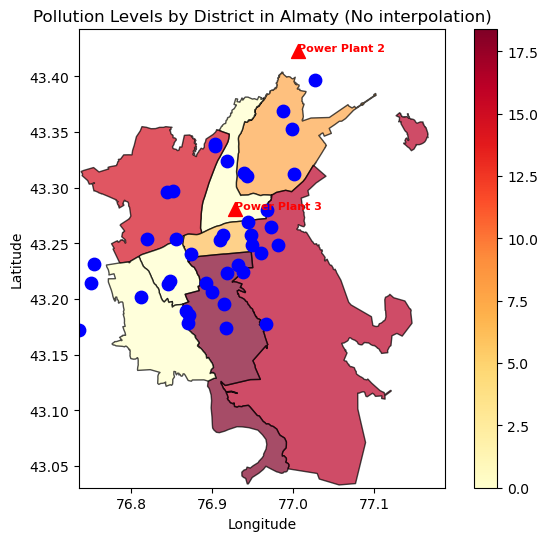

In [121]:
class AQApp(tk.Tk):
    """
    This class holds the main application, and ties together
    the main window, naigation menu etc.

    The application itself follows a Model-View-Controller principle
    where Controller is AQApp class and is responsible for tying up the main application, 
    View corresponds to individual tk.Frames reponsible for each page,
    and Model describes that Data and logic is designed to be handled by external classes (in my case, DataManipulator class)
    """
    def __init__(self):
        """
        Initializing the main app window and its subcomponents by creating instanes of every window (VizPage, CorrAnalysis etc.)

        Attributes:
            app_settings (dict): Stores custom user settings for font and font size
            frames (dict): is a dictionary that stores all the tkinter frames corresponding to their class names 
            where {key: 'class_name', value: 'class instance'}
            To get an idea of how to structure a multi-page tkinter application, I advised information available @
            https://www.geeksforgeeks.org/tkinter-application-to-switch-between-different-page-frames/
        """
        super().__init__()
        self.title("Almaty AirQ")   
        self.geometry("800x600")

        self.app_settings = {
            "theme": "Light",
            "font": "Arial",
            "font_size": 12
        }


        menubar = tk.Menu(self) 

        file_menu = tk.Menu(menubar, tearoff=0)
        menubar.add_cascade(label='File', menu=file_menu)
        file_menu.add_command(label='<< To menu', command=lambda: self.show_frame("HomePage"))
        file_menu.add_command(label='Open...', command=None)
        file_menu.add_separator()
        file_menu.add_command(label='Exit', command=self.exit_app)

        help_menu = tk.Menu(menubar, tearoff=0)
        help_menu.add_command(label='About', command=self.show_about)
        menubar.add_cascade(label='Help', menu=help_menu)

        # the entire page is one big cell consisting of a single row and column
        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)

        self.frames = {}
        for F in (HomePage, VizPage, CorrPage, SettingsPage, AboutPage):
            page_n = F.__name__
            frame = F(parent=self, controller=self)
            self.frames[page_n] = frame
            frame.grid(row=0, column=0, sticky="nsew") 

        self.show_frame("HomePage")

        self.config(menu=menubar)

    # allows to display the current frame by 'raising' it over another frames
    def show_frame(self, pagename):
        frame = self.frames[pagename]
        frame.tkraise()

    # the logic that allows to apply the user settings
    def apply_settings(self):
        settings = self.app_settings
        theme_colors = {
            "Light": {"bg": "white", "fg": "black"},
            "Dark": {"bg": "black", "fg": "white"},
        }
        theme = theme_colors.get(settings["theme"], theme_colors["Light"])

        for frame in self.frames.values():
            frame.configure(bg=theme["bg"])
            for widget in frame.winfo_children():
                if isinstance(widget, tk.Label) or isinstance(widget, tk.Button):
                    widget.configure(
                        font=(settings["font"], settings["font_size"]),
                        bg=theme["bg"],
                        fg=theme["fg"]
                    )


    def exit_app(self):
        self.destroy()

    def show_about(self):
        """Show About dialog"""
        tk.messagebox.showinfo("About", "Almaty AirQ Application\nVersion 0.01\nDeveloped as a Project Work for Scientific Programming in Python Course @ University of Nottingham")


class HomePage(tk.Frame):
    """
    Serves as an entry navigation to all the other application windows.
    Sets up the buttons that navigate to different pages of the application

    Atrributes:
        controller (AQApp)
    """
    def __init__(self, parent, controller):
        """
        Args:
            parent (tk.Tk): main application is a parent
            controller (AQApp)
        """
        super().__init__(parent) 
        self.controller = controller

        #configureing the layout of the frame window
        self.grid_rowconfigure(0, weight=1)  
        self.grid_rowconfigure(1, weight=0)  
        self.grid_rowconfigure(2, weight=0)  
        self.grid_rowconfigure(3, weight=0)  
        self.grid_rowconfigure(4, weight=0)  
        self.grid_rowconfigure(5, weight=0) 
        self.grid_rowconfigure(6, weight=1) 

        self.grid_columnconfigure(0, weight=1) 
        self.grid_columnconfigure(1, weight=0) 
        self.grid_columnconfigure(2, weight=1)

        self.configure(bg="#e0f7fa")

        # bg_image = tk.PhotoImage(file="bg_main.png")
        # bg_label = tk.Label(self, image=bg_image)
        # bg_label.place(relwidth=1, relheight=1)
        # bg_label.image = bg_image

        button_width = 20

        # this is for more appealing UI
        # when a mouse hovers the button, it changes its font and color
        # works by event listeners
        def on_enter(e):
            e.widget['bg'] = '#004d40' 
            e.widget['font'] = ("Helvetica", 10, "bold")

        def on_leave(e):
            e.widget['bg'] = 'grey' 
            e.widget['font'] = ("Helvetica", 10)

        label = tk.Label(self, text="AirQ Almaty", font=("Helvetica", 24), fg="#004d40", bg="#e0f7fa")
        label.grid(row=1, column=1, sticky="", padx=0, pady=0)

        vz_page_button = tk.Button(self, text="Data Visualization", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("VizPage"))
        vz_page_button.grid(row=2, column=1, sticky="", padx=20, pady=10)
        vz_page_button.bind("<Enter>", on_enter)
        vz_page_button.bind("<Leave>", on_leave)

        corr_page_button = tk.Button(self, text="Correlation Analysis", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("CorrPage"))
        corr_page_button.grid(row=3, column=1, sticky="", padx=20, pady=10)
        corr_page_button.bind("<Enter>", on_enter)
        corr_page_button.bind("<Leave>", on_leave)

        sttgs_page_button = tk.Button(self, text="Settings", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("SettingsPage"))
        sttgs_page_button.grid(row=4, column=1, sticky="", padx=20, pady=10)
        sttgs_page_button.bind("<Enter>", on_enter)
        sttgs_page_button.bind("<Leave>", on_leave)

        about_page_button = tk.Button(self, text="About", font=("Helvetica", 10), width=button_width, bg='grey', command=lambda: controller.show_frame("AboutPage"))
        about_page_button.grid(row=5, column=1, sticky="", padx=20, pady=10)
        about_page_button.bind("<Enter>", on_enter)
        about_page_button.bind("<Leave>", on_leave)



class VizPage(tk.Frame):
    """
    The page designaed to show the map af the city with corresponding sensor readings.

    The page allows the user to select the date ranges for which to show the map, choose interpolation methods
    to get insights about overall situation with pm2.5 in the city and around power plants

    Some Sensors lack data, and dduring the data pre-processing such values were replaced by 0's.

    Attributes:
        controller (AQApp)
        data_manipulator (DataManipulator)
        districts_gdf, date_var, date_var2 could be passed as variables
    """
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller
        self.data_manipulator = dataManipulator
        
        self.grid_columnconfigure(0, weight=0)  
        self.grid_columnconfigure(1, weight=1)  
        self.grid_rowconfigure(0, weight=0)  
        self.grid_rowconfigure(1, weight=1)  

        self.create_widgets()

    def _validate_inputs(self, start_date, end_date):
        if start_date > end_date:
            raise ValueError("Start date cannot be after end date.")

    def create_widgets(self):
        top_frame = tk.Frame(self, bg='#f0f0f0')
        top_frame.grid(row=0, column=0, columnspan=2, sticky='ew', pady=10)

        date_label = tk.Label(top_frame, text="Select Date:", bg='#f0f0f0', font=("Arial", 12))
        date_label.pack(side='left', padx=10, pady=5)

        date_var = tk.StringVar()
        date_entry = DateEntry(
            top_frame,
            textvariable=date_var,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry.pack(side='left', padx=10, pady=5)

        date_var2 = tk.StringVar()
        date_entry2 = DateEntry(
            top_frame,
            textvariable=date_var2,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry2.pack(side='left', padx=10, pady=5)

        #dropdown menu
        selected_option = StringVar()
        selected_option.set("No Interpolation")

        options = [ 
            "No Interpolation", 
            "Nearest neighbor", 
            "Linear", 
        ] 

        dropdown = tk.OptionMenu(top_frame, selected_option, *options)
        dropdown.pack(side='left', padx=10, pady=5)

        update_button = tk.Button(
            top_frame, 
            text="Update Map", 
            command=lambda: self.update_summary(date_var = date_var.get(), date_var2 = date_var2.get(), interpolation=selected_option.get())
        )
        update_button.pack(side='left', padx=10, pady=5)

        sidebar = tk.Frame(self, width=200, bg='#f0f0f0')
        sidebar.grid(row=1, column=0, sticky='ns', pady=10)

        title_label = tk.Label(sidebar, text="Data Visualization", font=("Helvetica", 16), bg='#f0f0f0')
        title_label.pack(anchor='nw', pady=10)

        summary_label = tk.Label(sidebar, text="Summary Statistics", font=("Helvetica", 12), bg='#f0f0f0')
        summary_label.pack(anchor='nw')

        self.stats_label = tk.Label(sidebar, text="", font=("Helvetica", 10), bg='#f0f0f0', justify="left")
        self.stats_label.pack(anchor='nw')

        self.map_frame = tk.Frame(self, bg='white')
        self.map_frame.grid(row=1, column=1, sticky='nsew', pady=10)

    def update_summary(self, date_var, date_var2, interpolation='No Interpolation'):
        """
        Responsible for the summary statistics on the left side of the window

        Args:
            date_var (_type_): _description_
            date_var2 (_type_): _description_
            interpolation (str, optional): Selected interpolatio method. Defaults to 'No Interpolation'.
        """
        selected_date = pd.to_datetime(date_var)
        selected_date2 = pd.to_datetime(date_var2)
        self._validate_inputs(selected_date, selected_date2)
        filtered_gdf = self.data_manipulator.filter_data(start_date=selected_date, end_date=selected_date2)

        # get pollution levels by each district
        # this would be almaty_boundaries with average sensor readings for each district
        avgpm25_districts_gdf = self.data_manipulator.calculate_pollution_by_district(filtered_gdf)

        self.plot_map(gdf=filtered_gdf, districts_gdf = avgpm25_districts_gdf, method=interpolation)

        min_val, max_val, avg_val, var_val, most_polluted_district = self.data_manipulator.get_statistics(filtered_gdf)

        avg_text = f"{avg_val:.2f}" if avg_val is not None else "NaN"
        var_text = f"{var_val:.2f}" if var_val is not None else "NaN"
        min_text = f"{min_val:.2f}" if min_val is not None else "NaN"
        max_text = f"{max_val:.2f}" if max_val is not None else "NaN"
        district_text = most_polluted_district if most_polluted_district else "No data"

        # this is the text of the stats_label which gets updates on every function call
        stats_text = (
            f"Average PM2.5: {avg_text}\n"
            f"Variance: {var_text}\n"
            f"Minimum: {min_text}\n"
            f"Maximum: {max_text}\n"
            f"Most Polluted District: {district_text}"
        )
        self.stats_label.config(text=stats_text)


    def plot_map(self, gdf, districts_gdf, method='No Interpolation'):
        """
        Plots the map on the canvas

        Args:
            gdf (geoDataFrame): dataframe with sensor readings, locations, power plant coals etc.
            method (str, optional): Interpolation method of choice. Defaults to 'No Interpolation'.
        """

        # get the interpolation grids from the data_manipulator class
        grid_z_masked, grid_lon, grid_lat = self.data_manipulator.interpolate(gdf=gdf, method=method)

        # set up plotting
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        # color map
        cmap = plt.get_cmap('Reds')
        interpolation_plot = ax.pcolormesh(grid_lon, grid_lat, grid_z_masked, cmap=cmap, shading='auto')

        district_plot = districts_gdf.plot(
                ax=ax,
                column='avg_pm25',
                cmap='YlOrRd',
                legend=True,
                edgecolor='black',
                alpha=0.7
        )

        # Add hover tooltips for districts
        cursor = mplcursors.cursor(district_plot.collections, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            if hasattr(sel.artist, "column") and sel.artist.column == "avg_pm25":
                district_name = self.districts_gdf.iloc[sel.index]["name"]
                pollution_level = self.districts_gdf.iloc[sel.index]["avg_pm25"]
                sel.annotation.set_text(f"{district_name}\nAvg PM2.5: {pollution_level:.2f}")

        # sensor locs
        gdf.plot(ax=ax, color='blue', markersize=80, marker='o', label='Sensor')

        # power plant locs
        power_plants_gdf = self.data_manipulator.get_power_plant_data()
        power_plants_gdf.plot(ax=ax, color='red', markersize=100, marker='^', label='Power Plants')

        # this allows to add names to the power plant locations
        for idx, row in power_plants_gdf.iterrows():
            ax.text(
                row.geometry.x, row.geometry.y,
                row['location'],
                fontsize=8, color='red', weight='bold'
            )

        plt.title(f"Pollution Levels by District in Almaty ({method.capitalize()})")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        # we now can redraw Tkinter canvas
        for widget in self.map_frame.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=self.map_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


class CorrPage(tk.Frame):
    """
    This page aims to show the clear relation between the amount of coal burnt in power plants
    and the amount of pm25 in the air across the city

    is not it better to pass isShowCP3 and isShowCP2 as variables insead of storing as class attributes? !!!!!!!!!!!!!!!!!!!!!!!!!!!!
    """
    def __init__(self, parent, controller):
        """
        Initilization of the class

        Args:
            parent (tk.TK)
            controller (AQApp)
            data_manipulator (DataManipulator)
        """
        super().__init__(parent)
        self.controller = controller
        self.data_manipulator = dataManipulator

        #the grids for the UI
        self.grid_columnconfigure(0, weight=0)  
        self.grid_columnconfigure(1, weight=1)  
        self.grid_rowconfigure(0, weight=0)  
        self.grid_rowconfigure(1, weight=1)  

        # method responsible for all the widgets
        self.create_widgets()

    def create_widgets(self):
        top_frame = tk.Frame(self, bg='#f0f0f0')
        top_frame.grid(row=0, column=0, columnspan=2, sticky='ew', pady=10)

        date_label = tk.Label(top_frame, text="Select Date:", bg='#f0f0f0', font=("Arial", 12))
        date_label.pack(side='left', padx=10, pady=5)

        self.date_var = tk.StringVar()
        date_entry = DateEntry(
            top_frame,
            textvariable=self.date_var,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry.pack(side='left', padx=10, pady=5)

        self.date_var2 = tk.StringVar()
        date_entry2 = DateEntry(
            top_frame,
            textvariable=self.date_var2,
            date_pattern='yyyy-mm-dd', 
            showweeknumbers=False,      
            maxdate=datetime.date(2020, 3, 25),               
            mindate=datetime.date(2019, 1, 1),  
            font=("Helvetica", 12)          
        )
        date_entry2.pack(side='left', padx=10, pady=5)

        self.isShowCP2 = tk.IntVar()
        self.isShowCP3 = tk.IntVar()

        checkbox1 = tk.Checkbutton(top_frame, text="Show Coal Plant 2", variable=self.isShowCP2)
        checkbox1.pack()

        checkbox2 = tk.Checkbutton(top_frame, text="Show Coal Plant 2", variable=self.isShowCP3)
        checkbox2.pack()

        update_button = tk.Button(
            top_frame, 
            text="Update Plot", 
            command=lambda: self.update_summary()
        )
        update_button.pack(side='left', padx=10, pady=5)

        sidebar = tk.Frame(self, width=200, bg='#f0f0f0')
        sidebar.grid(row=1, column=0, sticky='ns', pady=10)

        summary_label = tk.Label(sidebar, text="Summary Statistics", font=("Helvetica", 12), bg='#f0f0f0')
        summary_label.pack(anchor='nw')

        self.stats_label = tk.Label(sidebar, text="", font=("Helvetica", 10), bg='#f0f0f0', justify="left")
        self.stats_label.pack(anchor='nw')

        self.map_frame = tk.Frame(self, bg='white')
        self.map_frame.grid(row=1, column=1, sticky='nsew', pady=10)


    def update_summary(self):
        # here we are using the same code as in VizPage
        # it was not obvious to me how to deal with this reduntant code by now overcomplicating the project
        selected_date = pd.to_datetime(self.date_var.get())
        selected_date2 = pd.to_datetime(self.date_var2.get())
        
        filtered_gdf = self.data_manipulator.filter_data(start_date=selected_date, end_date=selected_date2)
        # maybe make get_districts return the most polluted districs as well?                           !!!!!!!!!!!!

        min_val, max_val, avg_val, var_val, most_polluted_district = self.data_manipulator.get_statistics(filtered_gdf)

        stats_text = (
            f"Average PM2.5: {avg_val:.2f}\n"
            f"Variance: {var_val:.2f}\n"
            f"Minimum: {min_val:.2f}\n"
            f"Maximum: {max_val:.2f}\n"
            f"Most Polluted District: {most_polluted_district}"
        )
        self.stats_label.config(text=stats_text)

        #the only difference is this line
        self.plot_frame(filtered_gdf, self.isShowCP2.get(), self.isShowCP3.get())

    def plot_frame(self, filtered_gdf, show_cp2, show_cp3):
        
        for widget in self.map_frame.winfo_children():
            widget.destroy()

        # Prepare the data for plotting
        # Group by date and calculate average PM2.5
        daily_avg = filtered_gdf.groupby('date')['Reading'].mean().reset_index()

        daily_cp2 = filtered_gdf.groupby('date')['ТЭЦ2, тонн'].mean().reset_index()
        daily_cp3 = filtered_gdf.groupby('date')['ТЭЦ3, тонн'].mean().reset_index()

        daily_avg['date'] = pd.to_datetime(daily_avg['date'])
        daily_cp2['date'] = pd.to_datetime(daily_cp2['date'])
        daily_cp3['date'] = pd.to_datetime(daily_cp3['date'])

        # preparing to plot
        fig, ax1 = plt.subplots(figsize=(8, 6))

        # labels for daily average PM2.5
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Average PM2.5 (µg/m³)', color='tab:blue', fontsize=12)

        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

        # pm2.5 readings
        ax1.plot(daily_avg['date'], daily_avg['Reading'], label='Average PM2.5', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

        # secondary axis for coal consumption
        ax2 = ax1.twinx()
        ax2.set_ylabel('Coal Burnt (tons)', color='tab:green', fontsize=12)

        if show_cp2:
            ax2.plot(daily_cp2['date'], daily_cp2['ТЭЦ2, тонн'], label='Coal Plant 2', color='tab:green', linestyle='--')
        if show_cp3:
            ax2.plot(daily_cp3['date'], daily_cp3['ТЭЦ3, тонн'], label='Coal Plant 3', color='tab:red', linestyle='--')

        ax2.tick_params(axis='y', labelcolor='tab:green')

        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        ax1.set_title('Trends in Air Pollution and Coal Consumption', fontsize=14)

        fig.tight_layout()

        # now we can show the fig on the canves
        canvas = FigureCanvasTkAgg(fig, master=self.map_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True)


class SettingsPage(tk.Frame):
    """
    This serves to improve the accessibilty of the app
    by allowing to adjust the font size of the UI as the user finds appropriate
    """
    def __init__(self, parent, controller):
        """
        Init.

        Args:
            parent (tk.Tk)
            controller (AQApp)
        """
        super().__init__(parent)
        self.controller = controller

        tk.Label(self, text="Settings", font=("Arial", 18)).pack(pady=10)

        # select themes
        tk.Label(self, text="Select Theme:", font=("Arial", 12)).pack(anchor="w", padx=20)
        theme_var = tk.StringVar(value="Light")
        theme_dropdown = tk.OptionMenu(self, theme_var, "Light", "Dark")
        theme_dropdown.pack(anchor="w", padx=20)

        # select fonts
        tk.Label(self, text="Select Font:", font=("Arial", 12)).pack(anchor="w", padx=20)
        font_var = tk.StringVar(value="Arial")
        font_dropdown = tk.OptionMenu(self, font_var, "Arial", "Helvetica", "Courier")
        font_dropdown.pack(anchor="w", padx=20)

        # font size slider
        tk.Label(self, text="Font Size:", font=("Arial", 12)).pack(anchor="w", padx=20)
        font_size_var = tk.IntVar(value=12)  # Default size
        font_size_slider = tk.Scale(self, from_=8, to=24, orient="horizontal", variable=font_size_var)
        font_size_slider.pack(anchor="w", padx=20)

        # apply
        save_button = tk.Button(self, text="Save Settings", command=lambda: self.save_settings(theme_var.get(), font_var.get(), font_size_var.get()))
        save_button.pack(pady=20)

    def save_settings(self, theme, font, font_size):
        """
        Saves the changes to the AQApp's app_settings dict.
        Applies the changes by calling controller.apply_settings()

        Args:
            theme (_type_): _description_
            font (_type_): _description_
            font_size (_type_): _description_
        """
        
        self.controller.app_settings["theme"] = theme
        self.controller.app_settings["font"] = font
        self.controller.app_settings["font_size"] = font_size

        self.controller.apply_settings()

        tk.messagebox.showinfo(
            "Settings Saved",
            f"Theme: {theme}\nFont: {font}\nFont Size: {font_size}",
        )


class AboutPage(tk.Frame):
    """
    Displays some general information
    """
    def __init__(self, parent, controller):
        super().__init__(parent)
        self.controller = controller

        self.plot_frame = tk.Frame(self)
        self.plot_frame.pack(fill="both", expand=True)




app = AQApp()

app.mainloop()

## Tests

The most critical parts of the project is related to the DataManipulator Class. So, I focus on testing the key methods of the class for the correctness of their outputs. 

In [122]:
# I use a little instance of the dataset to check results
little_gdf = combined_gdf[:5]
almaty_boundaries = gpd.read_file('notebook/almaty-districts.geo.json')
data_manipulator = DataManipulator(little_gdf, almaty_boundaries)

In [123]:
little_gdf

,Unnamed: 0,date,Sensor ID,Reading,name,geometry,"pm2.5, мкг","ТЭЦ2, тонн","ТЭЦ3, тонн"
0,0,2019-03-22,1,0.000000,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),89.203308,8643.0,0.0
1,1,2019-03-23,1,0.000000,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),90.783514,8171.0,0.0
2,2,2019-03-24,1,208.403433,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),47.493938,7133.0,0.0
3,3,2019-03-25,1,67.575610,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),45.113514,7711.0,0.0
4,4,2019-03-26,1,45.677083,Сейфуллина - Дулатова (TS225957),POINT (76.93900 43.31300),45.672026,7829.0,0.0


In [124]:
def test_statistics():
    min = 0
    max = 208.403433
    avg = (208.403433+67.575610+45.677083)/5
    var = ((208.403433-avg)**2 + (67.575610 - avg)**2 + (45.677083 - avg)**2 + 2*(0-avg)**2)/4


    tuple = data_manipulator.get_statistics(little_gdf)
    ret_min, ret_max, ret_avg, ret_var, ret_most_polluted_district = tuple

    assert (abs(min - ret_min) < 0.0001), f'Incorrect minimum value. Expected {min} but got {ret_min}!'
    assert (abs(max - ret_max) < 0.0001), f'Incorrect maximum value. Expected {max} but got {ret_max}!'
    assert (abs(avg - ret_avg) < 0.0001), f"Incorrectly calculated avg. Expected {avg} but got {ret_avg}!"
    assert (abs(var - ret_var) < 0.0001), f"Incorrectly calculated variance. Expected {var} but got {ret_var}!"

    print("All tests passed for statistics")


test_statistics()

All tests passed for statistics


In [125]:
def test_filter_data():
    start_date = pd.Timestamp('2019-03-25')
    end_date = pd.Timestamp('2019-03-26')

    expected_gdf = little_gdf[3:]
    ret_gdf = data_manipulator.filter_data(start_date, end_date)

    assert len(ret_gdf) == len(expected_gdf), f'Incorrect length. Expected {len(expected_gdf)} but got {len(ret_gdf)}'
    assert all(ret_gdf['date'] == expected_gdf['date']), "Filtered dates do not match expected dates"
    assert all(ret_gdf['Reading'] == expected_gdf['Reading']), "Filtered readings do not match expected readings"

    # if the end_date < start_date
    start_date = pd.Timestamp('2019-03-26')
    end_date = pd.Timestamp('2019-03-25')

    ret_gdf = data_manipulator.filter_data(start_date, end_date)

    assert len(ret_gdf) == 0, f'Incorrect length. Expected {0} but got {len(ret_gdf)}'

    # if the start_date is not in the dataset

    start_date = pd.Timestamp('2022-01-01')
    end_date = pd.Timestamp('2022-01-10')
    ret_gdf = data_manipulator.filter_data(start_date, end_date)
    assert len(ret_gdf) == 0, "incorrect"

    print("All tests passed for filter_data!")


test_filter_data()


All tests passed for filter_data!
